# 1. Imports

In [4]:
import pandas as pd
import numpy as np
import nltk
import re

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import ConfusionMatrixDisplay, precision_score, recall_score, f1_score
from sklearn.pipeline import Pipeline

# 2. Data preparation & understanding

### Define the stopwords for english language
We define the Set of stopwords for english, because is the language that texts on the dataframe are using.

In [5]:
nltk.download('punkt')

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package punkt to /Users/andres/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/andres/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Define the tokenizer function using word_tokenize

In [6]:
def tokenizer(text: str):
    return word_tokenize(text)

### Read data using Pandas

In [7]:
data = pd.read_csv('./DatosSuicidio/SuicidiosProyecto.csv', sep = ',', encoding = 'utf-8')

### Understanding how many rows and columns do we have and how are they labeled

In [8]:
data.shape

(195700, 3)

In [9]:
data.columns

Index(['Unnamed: 0', 'text', 'class'], dtype='object')

### Dropping first column
We decided to drop first column because it does not add any value to the model we want to make

In [10]:
data.drop(labels = ['Unnamed: 0'], axis = 'columns', inplace= True)

### Identifying the classification of the data

In [11]:
data['class'].value_counts(dropna = False, normalize = True)

non-suicide    0.562928
suicide        0.437072
Name: class, dtype: float64

### Selection TfidfVectorizer model
We selected TF-DIF model because of the size of the datase. Rather than using Bag of Words, we prefer TF-DIF by trying to find a fast and low cost solution.

In [12]:
tfidf = TfidfVectorizer(tokenizer = tokenizer, stop_words = stop_words, lowercase = True, strip_accents= 'ascii', max_df = 0.001)

### Separate the data into Train and Test datasets

In [13]:
X_train, X_test, y_train, y_test = train_test_split(data['text'], data['class'], test_size = 0.2, stratify = data['class'], random_state = 1)

### Apply Train dataset to TfdifVectorizer model

In [14]:
X_tfidf = tfidf.fit_transform(X_train)

/usr/local/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'ll", "'re", "'s", "'ve", 'could', 'might', 'must', "n't", 'need', 'sha', 'wo', 'would'] not in stop_words.
  warnings.warn(


### Verifying the length of the vocabulary of the dataset
We got this legth of the vocabulary by using the paramter "max_df" in the TfidfVectorizer class, because it reduces the amount of times a word appears in the dataset by not using it as a token

In [15]:
len(tfidf.vocabulary_)

165787

# Entrenamiento con Support Vector Machines

In [16]:
# Se crea el objeto del clasificador support vector.
# Usamos un kernel lineal ya que estamos lidiando con text classification
tfidf_model = svm.SVC(kernel = 'linear')

In [17]:
# Entrenamos el modelo usando los training sets. 
tfidf_model.fit(X_tfidf, y_train)

SVC(kernel='linear')

## Predictions

In [18]:
# Predecimos la respuesta para el test dataset
y_train_tfidf_predict = tfidf_model.predict(X_tfidf)
y_test_tfidf_predict = tfidf_model.predict(tfidf.transform(X_test))

## Confusion Matrix

### Train

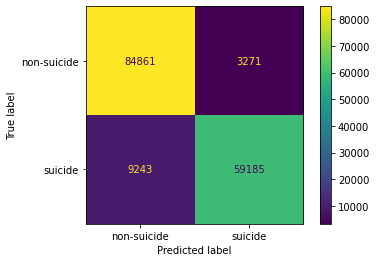

In [19]:
ConfusionMatrixDisplay.from_predictions(y_train, y_train_tfidf_predict)

### Test

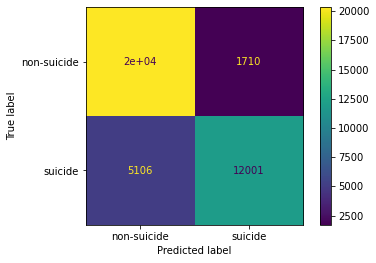

In [20]:
ConfusionMatrixDisplay.from_predictions(y_test, y_test_tfidf_predict)

## Scores Precision, Recall and F1

### Train

In [21]:
if len(tfidf_model.classes_) == 2:
    print('Precision:', precision_score(y_train, y_train_tfidf_predict, pos_label = 'suicide'))
    print('Recall:', recall_score(y_train, y_train_tfidf_predict, pos_label = 'suicide'))
    print('F1:', f1_score(y_train, y_train_tfidf_predict, pos_label = 'suicide'))
else:
    # Para casos no binarios, es común calcular las métricas para cada clase
    print('Precision:', precision_score(y_train, y_train_tfidf_predict, average = None))
    print('Recall:', recall_score(y_train, y_train_tfidf_predict, average = None))
    print('F1:', f1_score(y_train, y_train_tfidf_predict, average = None))

Precision: 0.9476271294991674
Recall: 0.8649237154381247
F1: 0.9043886189297394


## Scores Precision, Recall and F1

### Test

In [22]:
if len(tfidf_model.classes_) == 2:
    print('Precision:', precision_score(y_test, y_test_tfidf_predict, pos_label = 'suicide'))
    print('Recall:', recall_score(y_test, y_test_tfidf_predict, pos_label = 'suicide'))
    print('F1:', f1_score(y_test, y_test_tfidf_predict, pos_label = 'suicide'))
else:
    # Para casos no binarios, es común calcular las métricas para cada clase
    print('Precision:', precision_score(y_test, y_test_tfidf_predict, average = None))
    print('Recall:', recall_score(y_test, y_test_tfidf_predict, average = None))
    print('F1:', f1_score(y_test, y_test_tfidf_predict, average = None))

Precision: 0.8752826197943258
Recall: 0.7015256912375051
F1: 0.7788305535725875


### Predicting and exporting no-classified data
We are making a pipeline and precting over no-classified data, because SVM resulted the best model compared to KNeighborsClassifier and RandomForest.

In [23]:
pipeline = Pipeline(steps = [
    ('vectorizer', TfidfVectorizer(tokenizer = tokenizer, stop_words = stop_words, lowercase = True, strip_accents= 'ascii')),
    ('classifier', svm.SVC(kernel = 'linear'))
])

In [24]:
data_no_classified = pd.read_csv('DatosSuicidio/SuicidiosProyectoSinEtiqueta.csv', sep = ',', encoding = 'utf-8')

In [25]:
data_no_classified.drop(labels = ['Unnamed: 0'], axis = 'columns', inplace= True)

In [26]:
pipeline.fit(X_train, y_train)

/usr/local/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'ll", "'re", "'s", "'ve", 'could', 'might', 'must', "n't", 'need', 'sha', 'wo', 'would'] not in stop_words.
  warnings.warn(


Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(max_df=0.001,
                                 stop_words={'a', 'about', 'above', 'after',
                                             'again', 'against', 'ain', 'all',
                                             'am', 'an', 'and', 'any', 'are',
                                             'aren', "aren't", 'as', 'at', 'be',
                                             'because', 'been', 'before',
                                             'being', 'below', 'between',
                                             'both', 'but', 'by', 'can',
                                             'couldn', "couldn't", ...},
                                 strip_accents='ascii',
                                 tokenizer=<function tokenizer at 0x1323f9ee0>)),
                ('classifier', SVC(kernel='linear'))])

In [52]:
data_no_classified = pd.Series(data_no_classified['text'])

In [63]:
predicitions = pipeline.predict(data_no_classified)

In [64]:
classification = pd.Series(predicitions)

In [75]:
classification.shape

(10300,)

In [76]:
data_no_classified.shape

(10300,)

In [79]:
classification.reset_index(drop = True, inplace = True)

In [80]:
data_no_classified.reset_index(drop = True, inplace = True)

In [107]:
result_data = pd.concat([data_no_classified, classification], axis = 1, ignore_index = True)

In [108]:
result_data.rename(columns = {0:'text', 1:'class'}, inplace = True)

In [109]:
result_data.head()

,text,class
0,"Suicide Thoughts Getting StrongerOK, since the...",suicide
1,"Guys, I just asked my crush... if she wanted t...",non-suicide
2,I'm going to kill myselfOf course I'm not but ...,non-suicide
3,I did it! I slept facing the wall.\n\nOverall ...,suicide
4,I don't want to be dead...I want to be alive a...,non-suicide


In [110]:
result_data.to_csv('./result_data/results.csv', index_label= 'index')